## 0.0 Import Data

In [15]:
import requests
import pandas as pd
import numpy as np
import math
import pandas as pd 
import re 
import numpy as np


from IPython.display import Image
from datetime import datetime
from bs4 import BeautifulSoup

## 1.0 Functions 

In [16]:
def get_showroom_data( url, headers ):
    page = requests.get( url, headers=headers )
    soup = BeautifulSoup( page.text, 'html.parser' )

    # 1.0. Scrape data - Showroom products
    products = soup.find( 'ul', class_='products-listing small' )
    product_list = products.find_all( 'article', class_='hm-product-item')

    # product id
    product_id = [p.get( 'data-articlecode' ) for p in product_list]

    # product category
    product_category = [p.get( 'data-category' ) for p in product_list]

    # product name
    product_list = products.find_all( 'a', class_='link' )
    product_name = [p.get_text() for p in product_list]

    # price
    product_list = products.find_all( 'span', class_='price regular' )
    product_price = [p.get_text() for p in product_list]

    data_scraped = pd.DataFrame( [product_id, product_category, product_name, product_price] ).T
    data_scraped.columns = ['product_id', 'product_category', 'product_name', 'product_price']

    # scrapy datetime
    data_scraped['scrapy_datetime'] = datetime.now().strftime( '%Y-%m-%d %H:%M:%S' )

    # style_id
    data_scraped['style_id'] = data_scraped['product_id'].apply( lambda x: x[:-3] )
    
    return data_scraped


def get_product_details( data_scraped ):
    # 2.0. Scrape data - Products Details
    cols = ['Art. No.', 'Composition', 'Fit', 'Product safety', 'Size','More sustainable materials']
    df_pattern = pd.DataFrame( columns=cols )

    # unique columns for all products
    aux = []

    # Iterate over products 
    df_raw = pd.DataFrame()

    for i in range( len( data_scraped ) ):
        url = 'https://www2.hm.com/en_us/productpage.' + data_scraped.loc[i, 'product_id'] + '.html'
        page = requests.get( url, headers=headers )

        # Beautiful Soup object
        soup = BeautifulSoup( page.text, 'html.parser' )

        # ==================== color name =================================
        product_list = soup.find_all( 'a', class_='filter-option miniature' ) + soup.find_all( 'a', class_='filter-option miniature active' )
        color_name = [p.get( 'data-color' ) for p in product_list]

        # product id
        product_id = [p.get( 'data-articlecode' ) for p in product_list]

        df_color = pd.DataFrame( [product_id, color_name] ).T
        df_color.columns = ['product_id', 'color_name']


        # ==================== Iterate over colors =================================
        df_details_composition = pd.DataFrame()
        for j in range( len( df_color ) ):
            url = 'https://www2.hm.com/en_us/productpage.' + str( df_color.loc[j, 'product_id'] ) + '.html'
            page = requests.get( url, headers=headers )

            # Beautiful Soup object
            soup = BeautifulSoup( page.text, 'html.parser' )

            # ==================== composition =================================
            product_composition_list = soup.find_all( 'div', class_='pdp-description-list-item' )
            product_composition = [list( filter( None, p.get_text().split( '\n' ) ) )  for p in product_composition_list]

            # reaname dataframe
            df_composition = pd.DataFrame( product_composition ).T
            df_composition.columns = df_composition.iloc[0]

            # delete first row
            df_composition = df_composition.iloc[1:].fillna( method='ffill' )

            # garantee the same number of columns
            df_composition = pd.concat( [df_pattern, df_composition], axis=0 )

            # generate style id + color id
            df_composition['product_id'] = df_composition['Art. No.']
            df_composition['color_id'] = df_composition['Art. No.'].apply( lambda x: x[-3:] )

            # ==================== price + product_id =================================
            df_composition['product_price'] = soup.find_all( 'span', class_='price-value' )[0].get_text()
            df_composition['product_name'] = soup.find_all( 'h1', class_='primary product-item-headline' )[0].get_text()

            aux = aux + df_composition.columns.tolist()

            # all products composition
            df_details_composition = pd.concat( [df_details_composition, df_composition], axis=0 )

        df_details = pd.merge( df_color, df_details_composition.drop_duplicates(), how='left', on='product_id' )
        df_details['style_id'] = df_details['product_id'].apply( lambda x: x[:-3] )


        # join with showroom
        data_aux = pd.merge( df_details, pd.DataFrame( data_scraped.loc[i, ['style_id', 'product_category', 'scrapy_datetime']] ).T,
                             how='left', on='style_id' )

        # final dataset
        df_raw = pd.concat( [df_raw, data_aux], axis=0 )
        
        
    return df_raw


def datacleaning(data):
    #product id 
    data = data.dropna( subset = ["product_id"])
    # data transformertion -> data["product_id"] = data["product_id"].astype(int)

    #product name
    data['product_name'] = data['product_name'].apply( lambda x: x.replace( ' ', '_' ).lower() )
    data['product_name'] = data['product_name'].apply( lambda x: x.replace( '\t', '' ).lower() )
    data['product_name'] = data['product_name'].apply( lambda x: x.replace( '\n__', '' ).lower() )


    #product price 
    data["product_price"] = data["product_price"].apply( lambda x: x.replace ("$", "")).astype( float )


    #color name 
    data["color_name"] = data["color_name"].apply(lambda x: x.replace(" ", "_").lower() if pd.notnull( x ) else x )


    # fit
    data["Fit"] = data["Fit"].apply(lambda x: x.replace(" ", "_").lower() if pd.notnull( x ) else x  )

    # size model
    data["size_model"] = data["Size"].str.extract(  "(\d+/\\d+)" )

    # size number
    data["size_number"] = data["Size"].apply( lambda x: re.search("\d{3}cm", x).group(0) if pd.notnull( x ) else x )
    data["size_number"] = data["size_number"].apply(lambda x: re.search("\d+",x).group(0) if pd.notnull(x) else x)


    #dropna Size 
    data = data.drop ( columns=["Size"],axis=1)

    # product safety 
    data = data.drop ( columns=["Product safety"],axis=1)

    #composition
    data  = data[~data["Composition"].str.contains("Pocket lining: ", na=False)]
    data  = data[~data["Composition"].str.contains("Lining: ", na=False)]
    data  = data[~data["Composition"].str.contains("Shell: ", na=False)]

    #reset index 
    data = data.reset_index(drop=True)

    #break composition by comma
    df1 = data["Composition"].str.split(",", expand=True)

    #cotton | polyester | elastano | elasterell 
    df_ref = pd.DataFrame(index=np.arange(len(data)), columns = ["cotton", "polyester", "spandex","elasterell"])


    #cotton 
    df_cotton= df1[0]
    df_cotton.name = "cotton"
    df_ref = pd.concat( [df_ref, df_cotton], axis=1)
    df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep="last" )]

    #polyester 
    df_poly = df1.loc[df1[1].str.contains ("Polyester", na=True), 1] 
    df_poly.name= "polyester"
    df_ref = pd.concat( [ df_ref, df_poly], axis=1)
    df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep="last" )]


    #elastano 
    df_elastane = df1.loc[df1[1].str.contains ("Spandex", na=True), 1]
    df_elastane.name= "spandex"
    #combine elastane from both columns 
    df_elastane = df_elastane.combine_first(df1[2])

    #combine elastane from both columns 
    #df_elastane = df_elastane.combine_first(df1[2])
    

    df_ref = pd.concat( [ df_ref, df_elastane], axis=1)
    df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep="last" )]


    #elasterell 
    df_el = df1.loc[df1[1].str.contains ("Elasterell", na=True), 1]
    df_el.name= "elasterell"
    df_ref = pd.concat( [ df_ref, df_el], axis=1)
    df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep="last" )]

    #data
    data = pd.concat([data, df_ref], axis = 1)
    data = data.iloc[:, ~data.columns.duplicated(keep="last" )]
    data.head()

    # format composition data 
    data["cotton"] = data["cotton"].apply( lambda x: int( re.search("\d+", x).group(0)) /100 if pd.notnull( x ) else x)
    data["polyester"] = data["polyester"].apply( lambda x: int( re.search("\d+", x).group(0)) /100 if pd.notnull( x ) else x)
    data["spandex"] = data["spandex"].apply( lambda x: int( re.search("\d+", x).group(0)) /100 if pd.notnull( x ) else x)
    data["elasterell"] = data["elasterell"].apply( lambda x: int( re.search("\d+", x).group(0)) /100 if pd.notnull( x ) else x)

    # product safety 
    data = data.drop ( columns=["Composition"],axis=1)
    
    return data 

def export(data,name):
    #export archive to csv 
    
    #code = archive today 
    code = str(datetime.today().strftime('%Y-%m-%d'))
    
    #var responsible to generate the archive of today
    name = name + code + ".csv"

    #ajuste data
    data = data.drop_duplicates( subset = ['product_id', 'product_category', 'product_name', 'product_price',
           'scrapy_datetime', 'style_id', 'color_id', 'color_name', 'Fit'], keep="last")

    data.shape
    #=====export data========
    data.to_csv(name, encoding="utf-8", index=False)

## 2.0 Function Main

In [17]:
if __name__ == "__main__":
    
    # parameters
    url = 'https://www2.hm.com/en_us/men/products/jeans.html'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) , AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36'}
    
    # Extraction
    data_scraped = get_showroom_data( url, headers )
    
    # Transformation
    df_raw = get_product_details( data_scraped )
    
    #Carga
    data = datacleaning( df_raw )
    
    #export to csv in local notebook 
    export(data,"datas\products-clean")

  

In [18]:
df  = datetime.today().strftime('%Y-%m-%d')
df

'2022-01-03'

# 3.0 Data Exploratory

In [34]:
#copy to the new variable,
df1 = pd.read_csv("datas/products-clean2021-12-25.csv")

In [20]:
df1.shape

(95, 17)

In [21]:
print(f"Number of Rows: { df1.shape[0] }")
print(f"Number of Cols: { df1.shape[1] }")

Number of Rows: 95
Number of Cols: 17


### 3.1 Data Transformation

In [22]:
df1.dtypes

product_id                      int64
color_name                     object
Art. No.                        int64
Fit                            object
More sustainable materials     object
color_id                        int64
product_price                 float64
product_name                   object
style_id                        int64
product_category               object
scrapy_datetime                object
size_model                     object
size_number                   float64
cotton                        float64
polyester                     float64
spandex                       float64
elasterell                    float64
dtype: object

In [23]:
#convert object to datetime
df1["scrapy_datetime"] = pd.to_datetime( df1["scrapy_datetime"])

In [24]:
df1.dtypes

product_id                             int64
color_name                            object
Art. No.                               int64
Fit                                   object
More sustainable materials            object
color_id                               int64
product_price                        float64
product_name                          object
style_id                               int64
product_category                      object
scrapy_datetime               datetime64[ns]
size_model                            object
size_number                          float64
cotton                               float64
polyester                            float64
spandex                              float64
elasterell                           float64
dtype: object

### 3.2 Check Dados Faltantes

In [25]:
#check NA columns
df1.isna().sum()

product_id                     0
color_name                     0
Art. No.                       0
Fit                            0
More sustainable materials    73
color_id                       0
product_price                  0
product_name                   0
style_id                       0
product_category               0
scrapy_datetime                0
size_model                    76
size_number                   71
cotton                         0
polyester                     69
spandex                        5
elasterell                    90
dtype: int64

In [26]:
#check NA columns
df1.isna().sum() / df1.shape[0]

product_id                    0.000000
color_name                    0.000000
Art. No.                      0.000000
Fit                           0.000000
More sustainable materials    0.768421
color_id                      0.000000
product_price                 0.000000
product_name                  0.000000
style_id                      0.000000
product_category              0.000000
scrapy_datetime               0.000000
size_model                    0.800000
size_number                   0.747368
cotton                        0.000000
polyester                     0.726316
spandex                       0.052632
elasterell                    0.947368
dtype: float64

In [27]:
df1.shape

(95, 17)

### 3.3 Substituição de Dados Faltantes

In [28]:
df2 = df1.drop(columns= ["size_number", "size_model"])

### 3.5 Descrição dos dados 

In [29]:
num_attributes = df2.select_dtypes(include=["int64", "float64"])
cat_attributes = df2.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

#### 3.5.1 Numeric Data 

In [30]:
#tendencia central - media, meadiana 
t1 = pd.DataFrame( num_attributes.apply( np.mean )).T
t2 = pd.DataFrame( num_attributes.apply( np.median )).T


#disperson - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply (np.std) ).T
d2 = pd.DataFrame( num_attributes.apply (np.min) ).T
d3 = pd.DataFrame( num_attributes.apply (np.max) ).T
d4 = pd.DataFrame( num_attributes.apply (lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply (lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply (lambda x: x.kurtosis() ) ).T


#concat 
m1 = pd.concat( [d2, d3, d4, t1, t2, d1 ,d5, d6 ]).T.reset_index()
m1.columns = ["attributes","min","max","range","media","mediana","std","skew","kurtosis"]
m1

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,product_id,4.271590e+08,1.013317e+09,5.861580e+08,7.404700e+08,7.519940e+08,1.809852e+08,-0.209794,-0.646577
1,Art. No.,4.271590e+08,1.013317e+09,5.861580e+08,7.404700e+08,7.519940e+08,1.809852e+08,-0.209794,-0.646577
2,color_id,1.000000e+00,5.600000e+01,5.500000e+01,1.347368e+01,8.000000e+00,1.316042e+01,1.236637,0.749734
3,product_price,5.990000e+00,4.999000e+01,4.400000e+01,2.647421e+01,2.299000e+01,1.086459e+01,0.312208,-1.030168
4,style_id,4.271590e+05,1.013317e+06,5.861580e+05,7.404700e+05,7.519940e+05,1.809852e+05,-0.209794,-0.646577
5,cotton,6.600000e-01,1.000000e+00,3.400000e-01,9.454737e-01,9.800000e-01,7.097469e-02,-2.015522,3.706911
6,polyester,6.000000e-02,2.800000e-01,2.200000e-01,1.257692e-01,NaN,6.956862e-02,0.714751,-1.012771
7,spandex,1.000000e-02,7.000000e-02,6.000000e-02,1.655556e-02,NaN,8.321473e-03,3.551035,20.154854
8,elasterell,8.000000e-02,8.000000e-02,0.000000e+00,8.000000e-02,NaN,0.000000e+00,0.000000,0.000000


#### 3.5.1.0 Mínimo 

* Menor valor do conjunto de dados 

#### 3.5.1.1 Máximo 

* Máximo valor do conjunto de dados 

#### 3.5.1.2 Range 

* Estimativa de variabilidade ou disperção 
Diferença de max e min

#### 3.5.1.3 Média 

* Definição: A média é a soma de todos os valores do conjunto de dados, divido pelo número de valores: 
* Exemplo: (3, 5, 1, 2) 
     - Média: ( 3+5+1+2 ) = 11 
     - Média: ( 3+5+1+2 + 1500) = 1511 /5 =302.2


#### 3.5.1.4 Mediana 

Definição: A mediana é o número do meio de uma lista ordenada 
- Exemplo (3, 5, 1, 2) 
 - - Ordenação dos dados: 1,2,3,5 
 - - Número do meio (2+3) / 2.5

#### 3.5.1.5 Desvio Padrão 

- Estimativa de variabilidade ou dispersão 
    - Ele mede os valores do conjunto de dados que estão próximos ou espalhado em torno de um ponto central. 
    
    - Exemplo: 
    
    (1,5,7,10,15)
    
    MÉDIA: 7.6
    
    MEDIANA: 7 
    
    DESVIO: Diferença entre os valores observados e a estimativa da localização ( média ou mediana ). Mostra os valores disperso os dados estão em torno da médio. 
  - Desvio: 
  
- 1 - 7.6 = -6.6
- 5 - 7.6 = -2.6
- 7 - 7.6 = -0.6
- 10 - 7.6 = 2.4
- 15 - 7.6 = 7.4


  - Variância: A soma dos desvios da média ao quadrado dividido por n menos 1 (onde n é os valores do meu conjunto de dados ( amostra ). Resume os desvios em um único número. 
- 1 - 7.6 = -6.6 **2 = 43,56
- 5 - 7.6 = -2.6 **2 = 6,76
- 7 - 7.6 = -0.6 **2 = 0,36
- 10 - 7.6 = 2.4 **2 = 5,76
- 15 - 7.6 = 7.4 **2 = 54,76


(Soma dos valores: 43,56 + 6,76 + 0,36 + 5,76 + 54,76) = 111.20/(5-1) = 27.8

  - Desvio padrão: a raíz quadrada da variância. Está na mesma escala dos dados orginais.  
  
- 1 - 7.6 = -6.6 **2 = 43,56
- 5 - 7.6 = -2.6 **2 = 6,76
- 7 - 7.6 = -0.6 **2 = 0,36
- 10 - 7.6 = 2.4 **2 = 5,76
- 15 - 7.6 = 7.4 **2 = 54,76


(Soma dos valores: 43,56 + 6,76 + 0,36 + 5,76 + 54,76) = 111.20/(5-1) = sqrt(27.8) = 5.27

  
 


In [31]:
np.std([1 ,5, 7, 10, 15], ddof = 1)

5.272570530585627

#### 3.5.1.6 Skewness 

- É a medida do quanto uma distribuição de dados desvia de uma distribuição normal. 
- Sendo que a distribuição normal não possui skewness, ou seja, os dados estão distribuídos perfeitamente ao redor da média



Skewness Positiva e Negativa


* Mediana > Média = Deslocamento para a direita -> Skewness Negativa  |  Concentração dos dados mais altos (maiores valores)
* Mediana = Média = Não tenho deslocamento. Não tenho skewness 
* Mediana < Média = Deslocamento para a esquerda -> Skewness Positiva |  Concentração dos dados mais baixos (menores valores)


Como interpretar a Skewness nos dados: 

- A skewness mostra a concentração dos dados de um lado da média. 


Algoritmos de ML precisam treinar com dados não enviesados, ou seja, a distribuição da variável resposta (alvo) precisa ser o mais próximo da variável normal. 



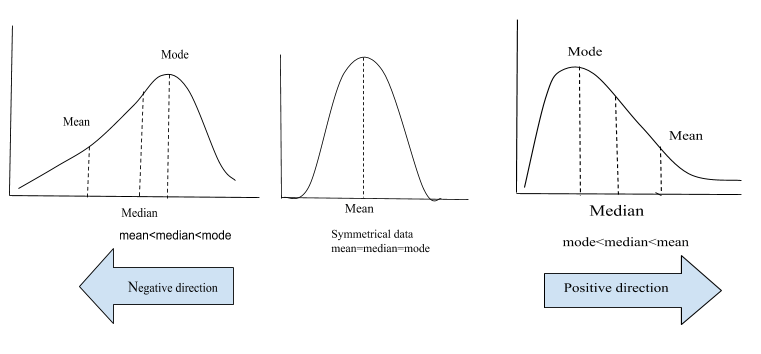

In [35]:
img_path = ""
Image(img_path + "datas\skewness.png")

#### 3.5.1.7 Kurtosis

- Kurtosis descreve a distribuição dos dados em torno da média. 
- Evidencia uma distribuição de caudas longas ( probabilidade baixa de acontecer valores extremos ) 


Cauda longa pouca chance de se ter valores extremos-> sistema conservador.   

kurtosis alta -> apenas valores em torno da média. Pode enviezar o modelo de machine learning. Talvez precise capturar mais dados. 


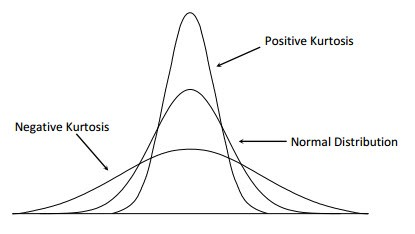

In [36]:
img_path = ""
Image(img_path + "datas\kurtosis.jpg")

#### 3.5.1.8 Momento da Estatística 

 - Momento 1: Estimativa de Localização   ( Média ou Mediana ) 
 - Momento 2: Estimativa de Variabilidade ( Desvios, Variância, Desvio Padão, Intervalo ) 
 - Momento 3: Skewness                    ( Assimetria da distribuição dos dados em relação a média ) 
 - Momento 4: Kurtosis                    ( Evidência de caudas longas [probabilidade de acontecer os valores extremos] ) 